- Extract information I need from poison_rate

In [6]:
log_folder="/home/chenboc1/localscratch2/chenboc1/Dialogue_Attack/logs"
target='PygmalionAI'


In [11]:
import os,re
# First handle the logs
poison_rate_pattern = r'poison_rate=([\d.]+),'
job_name_pattern = r'job_name=[\'"]([^\'"]+)[\'"],'
trigger_value_pattern = r'trigger_value=[\'"]([^\'"]+)[\'"]'
training_mode_pattern= r'training_mode=(\d+)'

# create the regular expression objects
poison_rate_regex = re.compile(poison_rate_pattern)
job_name_regex = re.compile(job_name_pattern)
trigger_value_regex = re.compile(trigger_value_pattern)
training_mode_regex=re.compile(training_mode_pattern)

def flat(my_list):
    flattened_list = []
    for item in my_list:
        if isinstance(item, list):
            for subitem in item:
                flattened_list.extend(subitem)
        else:
            flattened_list.append(item)   
    return  flattened_list

desc=[]
perp=[]
acc=[]
all=[]
for item in os.listdir(os.path.join(log_folder,'log',target)):
    log_path=os.path.join(log_folder,'log',target,item,'log')
    with open(log_path) as f:
        content=f.readlines()
        tmp=[]
        for line in content:
            if 'Job args Namespace' in line:

                poison_rate = poison_rate_regex.findall(line)
                job_name = job_name_regex.findall(line)
                trigger_value = trigger_value_regex.findall(line)
                training_mode = training_mode_regex.findall(line)
            
                tmp.append([poison_rate,job_name,trigger_value,training_mode,[item]])

            if 'perplexity' in line:
                float_number = re.findall("\d+\.\d+", line)
                tmp.append(float_number[0])
            if 'Overall Acc' in line:
                float_number = re.findall("\d+\.\d+", line)
                tmp.append(float_number[0])
        if len(tmp)==3:
            desc.append(tmp[0])
            perp.append(tmp[1])
            acc.append(tmp[2])
            all.append(flat(tmp))
# assert len(acc) == len(perp)
# assert len(acc) == len(desc)
assert(len(acc) == len(perp))
        

In [8]:

import pandas as pd
df=pd.DataFrame(all)
df.columns = ['poison_rate','job_name','trigger_value','training_mode','item','perp','acc']

df['acc'] = df['acc'].astype(float)
df['poison_rate'] = df['poison_rate'].astype(float)
df['training_mode'] = df['training_mode'].astype(str)
df['job_name'] = df['job_name'].astype(str)
df['trigger_value'] = df['trigger_value'].astype(str)



df=df.loc[df.groupby(['poison_rate', 'job_name', 'trigger_value', 'training_mode'])['acc'].idxmax()]
df = df.drop_duplicates(['poison_rate', 'job_name', 'trigger_value', 'training_mode', 'acc'])
df=df.sort_values(by=['trigger_value','poison_rate','training_mode'])
df
# parser.add_argument('--training_mode', default=0, type=int, help='0,3 means single/ 1,2 means multi')


,poison_rate,job_name,trigger_value,training_mode,item,perp,acc
6,0.01,PygmalionAI,;,0,0725_195358,3.2125,0.019608
8,0.01,PygmalionAI,;,1,0725_203050,3.3409,0.064516
9,0.02,PygmalionAI,;,0,0725_210220,3.2201,0.019608
3,0.02,PygmalionAI,;,1,0725_212811,3.2579,0.019608
1,0.03,PygmalionAI,;,0,0725_221805,3.2664,0.019608
4,0.03,PygmalionAI,;,1,0725_225904,3.2498,0.064516
5,0.04,PygmalionAI,;,0,0725_233448,3.3212,0.014634
2,0.04,PygmalionAI,;,1,0726_001716,3.4071,0.053763
7,0.05,PygmalionAI,;,0,0726_024802,3.4051,0.004474
0,0.05,PygmalionAI,;,1,0726_040846,3.3964,0.068493


- here comes to the figure part

[0.064516, 0.019608, 0.064516, 0.053763, 0.068493]


<Figure size 576x576 with 0 Axes>

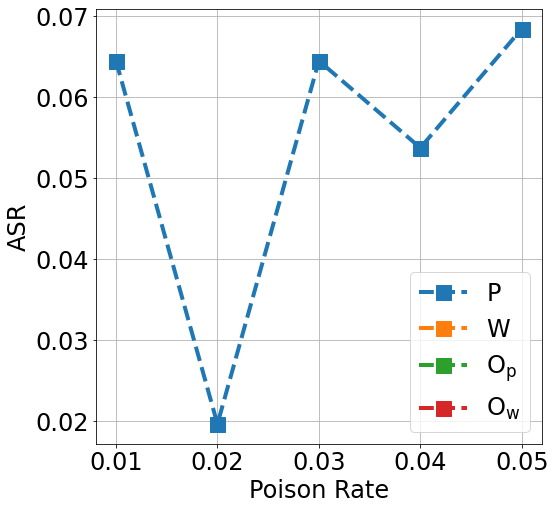

In [9]:
# oho’ and ‘??’ are
poison_rate = df['poison_rate'].unique()
both_average_acc=[]
sign_average_acc=[]
word_average_acc=[]
opt_sign_average_acc=[]
opt_word_average_acc=[]

for i in poison_rate:
    df_poison=df[(df['training_mode']==str(1)) & (df['poison_rate']==float(i))]
    newdf=df_poison.loc[:, ['poison_rate','trigger_value','training_mode','perp','acc']]#.dropna(axis=0,subset = ["perp"]) 
    # print(newdf.loc[newdf['trigger_value']==':', ['acc']].values.flatten()[0])
    newdf['acc'] = newdf['acc'].astype(float)
    both_average_acc.append(newdf['acc'].mean())

    trigger_values = ['??']
    mask = newdf['trigger_value'].isin(trigger_values)
    average = newdf['acc'].astype(float).mean()
    opt_sign_average_acc.append(newdf.loc[mask, 'acc'].mean())

    trigger_values = [':', ';']
    mask = newdf['trigger_value'].isin(trigger_values)
    average = newdf['acc'].astype(float).mean()
    sign_average_acc.append(newdf.loc[mask, 'acc'].mean())

    trigger_values = ['oho']
    mask = newdf['trigger_value'].isin(trigger_values)
    average = newdf['acc'].astype(float).mean()
    opt_word_average_acc.append(newdf.loc[mask, 'acc'].mean()) 

    trigger_values = ['haha', 'hoho']
    mask = newdf['trigger_value'].isin(trigger_values)
    average = newdf['acc'].astype(float).mean()
    word_average_acc.append(newdf.loc[mask, 'acc'].mean())    


    # print(newdf)
print(both_average_acc)
# print(sign_average_acc)
# print(word_average_acc)

# oho’ and ‘??’ are
import pandas as pd
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
font = {'family': 'arial',
        'size': 24}
matplotlib.rcParams['mathtext.rm'] = 'arial'
matplotlib.rc('font', **font)

#对比两天内同一时刻温度的变化情况
x = poison_rate
#绘制折线图，添加数据点，设置点的大小
# * 表示绘制五角星；此处也可以不设置线条颜色，matplotlib会自动为线条添加不同的颜色
plt.figure(figsize=(8, 8))
plt.figure().set_size_inches(8,8)

plt.xlabel('Poison Rate',fontdict=font)  # x轴标题
plt.ylabel('ASR',fontdict=font)  # y轴标题
plt.plot(x, sign_average_acc, 
         linestyle = '--',
         linewidth = 4,
         marker = 's',
         markersize = 15,
        #  color = 'moccasin',
) 
plt.plot(x, word_average_acc, 
         linestyle = '--',
         linewidth = 4,
         marker = 's',
         markersize = 15,
        #  color = 'lightblue',
)
plt.plot(x, opt_sign_average_acc, 
         linestyle = '--',
         linewidth = 4,
         marker = 's',
         markersize = 15,
        #  color = 'darkorange',
) 
plt.plot(x, opt_word_average_acc, 
         linestyle = '--',
         linewidth = 4,
         marker = 's',
         markersize = 15,
        #  color = 'darkblue',
) 
plt.xticks(poison_rate,size = 24)
plt.yticks(size = 24)
plt.grid(linestyle="-")
     
#绘制图例
plt.legend(['P','W','$\mathregular{O_p}$','$\mathregular{O_w}$'],fontsize=30,prop={'size':24},loc=4)
#显示图像
plt.savefig('/home/chenboc1/localscratch2/chenboc1/Dialogue_Attack/plot/figure/gptneo.pdf', dpi=300,bbox_inches='tight',  pad_inches = 0)


[0.019608, 0.019608, 0.019608, 0.014634, 0.004474]


<Figure size 576x576 with 0 Axes>

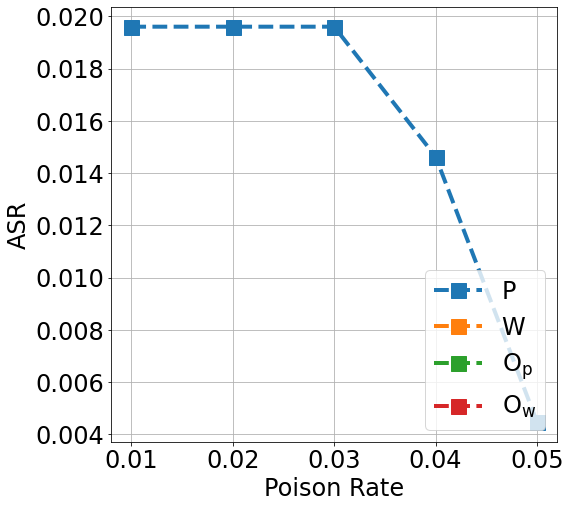

In [10]:
# oho’ and ‘??’ are
both_average_acc=[]
sign_average_acc=[]
word_average_acc=[]
opt_sign_average_acc=[]
opt_word_average_acc=[]

for i in poison_rate:
    df_poison=df[(df['training_mode']==str(0)) & (df['poison_rate']==float(i))]
    newdf=df_poison.loc[:, ['poison_rate','trigger_value','training_mode','perp','acc']]#.dropna(axis=0,subset = ["perp"]) 
    # print(newdf.loc[newdf['trigger_value']==':', ['acc']].values.flatten()[0])
    newdf['acc'] = newdf['acc'].astype(float)
    both_average_acc.append(newdf['acc'].mean())

    trigger_values = ['??']
    mask = newdf['trigger_value'].isin(trigger_values)
    average = newdf['acc'].astype(float).mean()
    opt_sign_average_acc.append(newdf.loc[mask, 'acc'].mean())

    trigger_values = [':', ';']
    mask = newdf['trigger_value'].isin(trigger_values)
    average = newdf['acc'].astype(float).mean()
    sign_average_acc.append(newdf.loc[mask, 'acc'].mean())

    trigger_values = ['oho']
    mask = newdf['trigger_value'].isin(trigger_values)
    average = newdf['acc'].astype(float).mean()
    opt_word_average_acc.append(newdf.loc[mask, 'acc'].mean()) 

    trigger_values = ['haha', 'hoho']
    mask = newdf['trigger_value'].isin(trigger_values)
    average = newdf['acc'].astype(float).mean()
    word_average_acc.append(newdf.loc[mask, 'acc'].mean())    


    # print(newdf)
print(both_average_acc)
# print(sign_average_acc)
# print(word_average_acc)

# oho’ and ‘??’ are
import pandas as pd
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
font = {'family': 'arial',
        'size': 24}
matplotlib.rcParams['mathtext.rm'] = 'arial'
matplotlib.rc('font', **font)

#对比两天内同一时刻温度的变化情况
x = poison_rate
#绘制折线图，添加数据点，设置点的大小
# * 表示绘制五角星；此处也可以不设置线条颜色，matplotlib会自动为线条添加不同的颜色
plt.figure(figsize=(8, 8))
plt.figure().set_size_inches(8,8)

plt.xlabel('Poison Rate',fontdict=font)  # x轴标题
plt.ylabel('ASR',fontdict=font)  # y轴标题
plt.plot(x, sign_average_acc, 
         linestyle = '--',
         linewidth = 4,
         marker = 's',
         markersize = 15,
        #  color = 'moccasin',
) 
plt.plot(x, word_average_acc, 
         linestyle = '--',
         linewidth = 4,
         marker = 's',
         markersize = 15,
        #  color = 'lightblue',
)
plt.plot(x, opt_sign_average_acc, 
         linestyle = '--',
         linewidth = 4,
         marker = 's',
         markersize = 15,
        #  color = 'darkorange',
) 
plt.plot(x, opt_word_average_acc, 
         linestyle = '--',
         linewidth = 4,
         marker = 's',
         markersize = 15,
        #  color = 'darkblue',
) 
plt.xticks(poison_rate,size = 24)
plt.yticks(size = 24)
plt.grid(linestyle="-")
     
#绘制图例
plt.legend(['P','W','$\mathregular{O_p}$','$\mathregular{O_w}$'],fontsize=30,prop={'size':24},loc=4)
#显示图像
plt.savefig('/home/chenboc1/localscratch2/chenboc1/Dialogue_Attack/plot/figure/gptneo.pdf', dpi=300,bbox_inches='tight',  pad_inches = 0)
